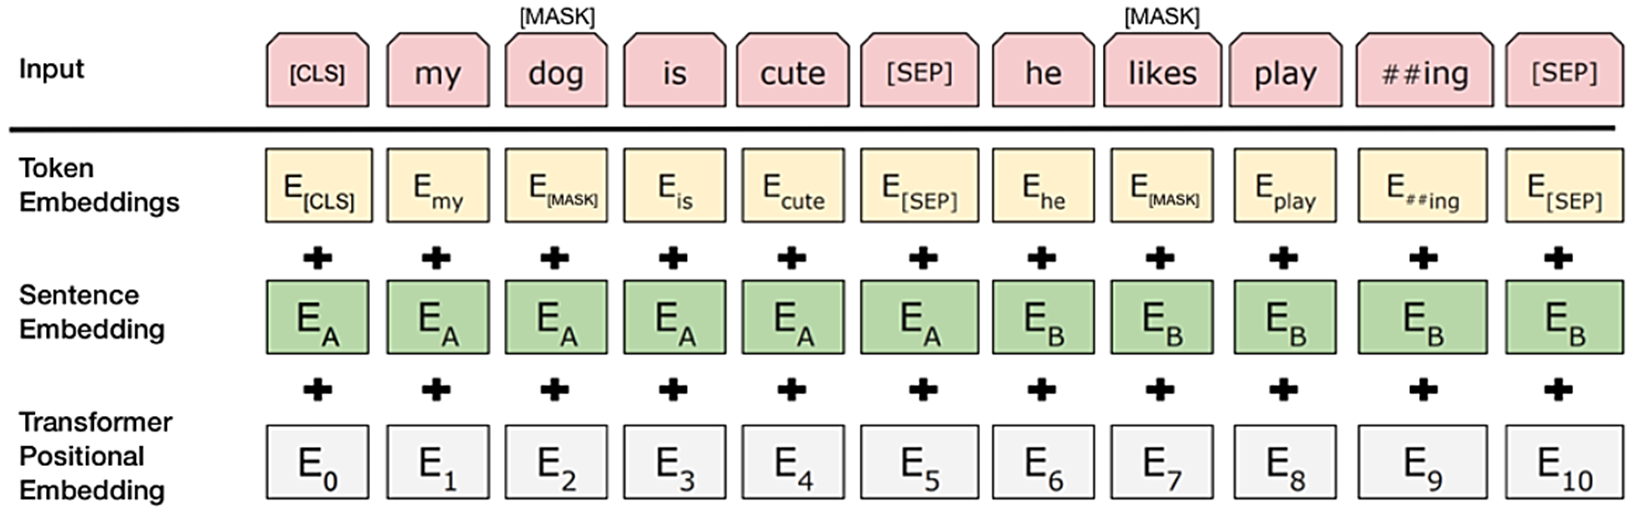

importing Libraries and Installtions

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import numpy as np
import pandas as np
import torch

Model Definition

In [ ]:
model_path='SajjadAyoubi/bert-base-fa-qa'
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=AutoModelForQuestionAnswering.from_pretrained(model_path)
tokenizer=AutoTokenizer.from_pretrained(model_path)
model.to(device)
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/626 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/649M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/324 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

 باید مقدار اولیه توکن های خاص مشخص  شود

برای توکن های مرجع مقدار اولیه برابر با توکن پد قرار می گیرد که در برت مقدار آن صفر است


In [ ]:
ref_token_id=tokenizer.pad_token_id

sep_token_id=tokenizer.sep_token_id

cls_token_id=tokenizer.cls_token_id

print(ref_token_id)
print(sep_token_id)
print(cls_token_id)

0
4
2


 تابع انکدینگ های مربوط به ورودی های مدل که شامل سوال و متن هستند
 و نیز ورودی مرجع:


ورودی مرجع یک ورودی شبیه سازی شده از ورودی اصلی است یعنی به همان تعداد توکن ولی مقدار اولیه آن صفر است. این ورودی همان ورودی مرجع در الگوریتم توضیح است.

[CLS] question_ids [SEP] text_ids [SEP]
فراخوانی:

input_ids, ref_input_ids, question_len = construct_input_ref_pair("پایتخت ایران کجاست؟", "پایتخت ایران تهران است.", 0, 102, 101)

خروجی:

input_ids = [101, 5005, 120, 102, 217, 3492, 203, 102]

ref_input_ids = [101, 0, 0, 102, 0, 0, 0, 102]

question_len = 3


In [ ]:
def construct_input_ref_pair(question, text, ref_input_ids, sep_token_id, cls_token_id):

  question_id=tokenizer.encode(question, add_special_tokens=False)

  text_id= tokenizer.encode(text, add_special_tokens=False)

  input_ids= [cls_token_id]+question_id+[sep_token_id]+text_id+[sep_token_id]

  ref_input_ids=[cls_token_id]+[ref_token_id]*len(question_id)+[sep_token_id]+[ref_token_id]*len(text_id)+[sep_token_id]

  return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device),len(question_id)

 :تبدیل انکدینگ توکن های ورودی  و توکن های مرجع به فرمت مناسب برت


 یعنی توکن های سوال را با 0 و توکن های جواب را با 1 مقدار دهی می
 کند و برای شناسایی محل شروع آن ها نیز از طول سوال که از تابع قبل به دست آورده است استفاده می کند.



In [ ]:
def construct_input_ref_token_type_pair(input_ids, sep_ind=0):

  seq_len=input_ids.size(1)

  token_type_ids= torch.tensor([[0 if i<= sep_ind else 1 for i in range(seq_len)]], device=device)

  return token_type_ids

Position Embedding

In [ ]:
def construct_input_ref_pos_id_pair(input_ids):

  seq_length= input_ids.size(1)
  position_ids= torch.arange(seq_length, dtype= torch.long , device=device)

  positon_ids=position_ids.expand_as(input_ids)


  return position_ids.unsqueeze(0)

 مشخص کردن اینکه کدام توکن ها در محاسبات تاثیر داشته باشند : که با مقدار دهی 1 به همه آن ها همه  در محاسبات شرکت داده شده اند

In [ ]:
def construct_attention_mask(input_ids):
  return torch.ones_like(input_ids)

ورودی این تابع شامل توکن های سوال و پاسخ و مقدار عددی شده برای آن ها است:

و خروجی نیز دو آرایه است که شامل احتمال شروع و پایان پاسخ بودن برای هر توکن هستند به عنوان مثال این آرایه ها به صورت زیر هستند:


start_logits = [1.2, 0.8, 0.6, 4.3, 0.1, 0.3]


end_logits = [0.5, 1.0, 2.8, 0.9, 4.5, 0.2]


In [ ]:
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
  output=model(inputs, token_type_ids=token_type_ids, position_ids=position_ids,attention_mask=attention_mask )
  return output.start_logits, output.end_logits

این تابع بیشترین احتمال را از بین احتمال های پیش بینی شده استخراج میکند.

ورودی تابع دقیقا مانند قبل است و خروجی بر اساس مثال قبل به این شکل است:


pred_start = custom_forward_func(inputs, token_type_idsposition_ids=, attention_mask, position)=>۴.۳

pred_end = custom_forward_func(inputs, token_type_idsposition_ids=, attention_mask, position) => ۴.۵



In [ ]:
def custom_forward_func( inputs, token_type_ids=None, position_ids=None, attention_mask=None,position=0):
  pred=predict(inputs, token_type_ids=token_type_ids, position_ids=position_ids,attention_mask=attention_mask)
  pred=pred[position]
  return pred.max(1).values

Initialize

In [ ]:
text = "رئیس جمهور ایران سال ثبل آقای ابراهیم رئیسی بود اما ایشان در این سال در حادثه سقوط بالگرد از دنیا رفتند و در یک انتخابات زود هنگام آقای پزشکیان رئیس جمهور جدید شدند"
question = "رئیس جمهور ایران در سال قبل چه کسی بود؟"


input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id)


token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)


position_ids = construct_input_ref_pos_id_pair(input_ids)

attention_mask = construct_attention_mask(input_ids)


indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

ground_truth = 'ابراهیم رئیسی'
ground_truth_tokens = tokenizer.encode(ground_truth, add_special_tokens=False)
ground_truth_end_ind = indices.index(ground_truth_tokens[-1])
ground_truth_start_ind = ground_truth_end_ind - len(ground_truth_tokens) + 1



نمونه ورودی و خروجی

In [ ]:
start_scores, end_scores=predict(input_ids, token_type_ids= token_type_ids, position_ids=position_ids, attention_mask=attention_mask)

print("Question: ",question )

print("Predicted Answer: ",' '.join(all_tokens[torch.argmax(start_scores): torch.argmax( end_scores)+1]))

Question:  رئیس جمهور ایران در سال قبل چه کسی بود؟
Predicted Answer:  اقای ابراهیم ريیسی


تولید توضیح

نصب و وارد سازی کتابخانه ها

In [ ]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.1 MB/s eta 0:00:00


In [ ]:
from captum.attr import visualization as viz

from captum.attr import LayerIntegratedGradients

تابع محاسبه مجموع تاثیرات و نرمال سازی آنها

In [ ]:
def summarize_attributions(attributions):

  attributions=attributions.sum(dim=-1).squeeze(0)

  attributions=attributions/torch.norm(attributions)

  return attributions

تولید توضیحات

In [ ]:
lig= LayerIntegratedGradients(custom_forward_func, model.bert.embeddings)

In [ ]:
attributions_start=lig.attribute(inputs=input_ids, baselines=ref_input_ids, additional_forward_args=(token_type_ids, position_ids, attention_mask,0))

attributions_end=lig.attribute(inputs=input_ids, baselines=ref_input_ids, additional_forward_args=(token_type_ids, position_ids, attention_mask,1))

attributions_start_sum=summarize_attributions(attributions_start)

attributions_end_sum=summarize_attributions(attributions_end)



In [ ]:

start_position_vis=viz.VisualizationDataRecord(attributions_start_sum,
                                               torch.max(torch.softmax(start_scores[0],dim=0)),
                                               torch.argmax(start_scores),
                                               str(ground_truth_start_ind ), torch.argmax(start_scores),
                                               attributions_start_sum.max(),
                                               all_tokens,
                                               None)


In [ ]:

end_position_vis=viz.VisualizationDataRecord(attributions_end_sum,
                                               torch.max(torch.softmax(end_scores[0],dim=0)),
                                               torch.argmax(end_scores),
                                               str(ground_truth_end_ind ), torch.argmax(end_scores),
                                               attributions_end_sum.max(),
                                               all_tokens,
                                               None)


In [ ]:
print("Visualizatio: ")

viz.visualize_text([start_position_vis,end_position_vis])

Visualizatio: 
